In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_root = '/content/drive/My Drive/data/traffic_series/traffic.csv'

In [ ]:
df = pd.read_csv(data_root)

In [ ]:
df.head(30)

,DateTime,Junction,Vehicles,ID
DateTime,,,,
2015-11-01 00:00:00,2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,2015-11-01 04:00:00,1,9,20151101041
2015-11-01 05:00:00,2015-11-01 05:00:00,1,6,20151101051
2015-11-01 06:00:00,2015-11-01 06:00:00,1,9,20151101061
2015-11-01 07:00:00,2015-11-01 07:00:00,1,8,20151101071
2015-11-01 08:00:00,2015-11-01 08:00:00,1,11,20151101081


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB


In [ ]:
df.DateTime = pd.to_datetime(df.DateTime)

In [ ]:
df.set_index(df.DateTime, inplace=True)

In [ ]:
df.drop('DateTime', axis=1, inplace=True)

In [ ]:
df.head()

,DateTime,Junction,Vehicles,ID
DateTime,,,,
2015-11-01 00:00:00,2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
# mean vehicles per week?
df_weekly = df.groupby(df.DateTime.dt.week)['Junction', 'Vehicles'].mean()
df_daily = df.groupby(df.DateTime.dt.day)['Junction', 'Vehicles'].mean()
#plt.figure(figsize=(20, 6))
#plt.plot(df.DateTime.dt.year, df['Vehicles'])
#plt.show()
df_daily

,Junction,Vehicles
DateTime,,
1,2.181818,21.891414
2,2.181818,22.864268
3,2.181818,22.316288
4,2.181818,21.298611
5,2.181818,21.570076
6,2.181818,22.208965
7,2.181818,21.938131
8,2.181818,22.209596
9,2.181818,22.999369


In [ ]:
df.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [ ]:
df.loc['2015-11-01']

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041
...,...,...,...
2015-11-01 19:00:00,3,5,20151101193
2015-11-01 20:00:00,3,11,20151101203
2015-11-01 21:00:00,3,8,20151101213


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
# replace with IQR
q1 = np.quantile(df.Vehicles, q=0.25)
q3 = np.quantile(df.Vehicles, q=0.75)
upper_bound = q3 + 1.5 * (q3 - q1)
df.loc[df.Vehicles > upper_bound, 'Vehicles'] = upper_bound

In [ ]:
df_first_day = df.loc['2015-11-01']
hourly = df_first_day.groupby(df_first_day.DateTime.dt.hour, as_index=False)['Vehicles'].sum()

In [ ]:
df_daily = df.groupby(df.index, as_index=False)['Vehicles'].sum()

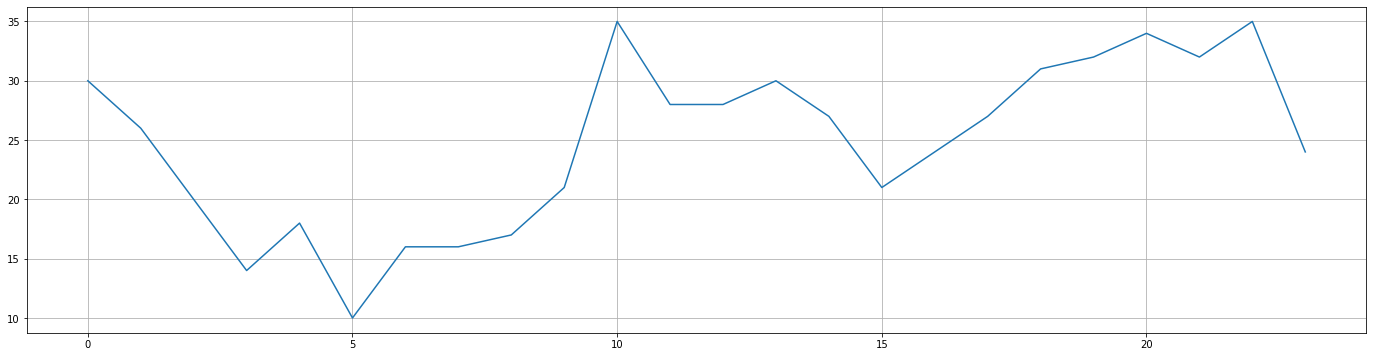

In [ ]:
plt.figure(figsize=(24, 6))
plt.plot(hourly.index, hourly.Vehicles)
plt.grid()
plt.show()

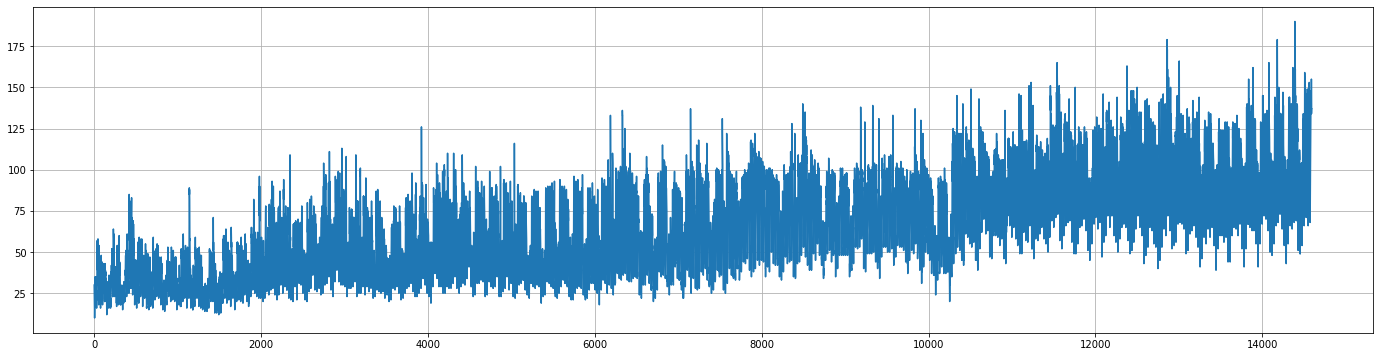

In [ ]:
plt.figure(figsize=(24, 6))
plt.plot(df_daily.index, df_daily.Vehicles)
plt.grid()
plt.show()
# have some outliers

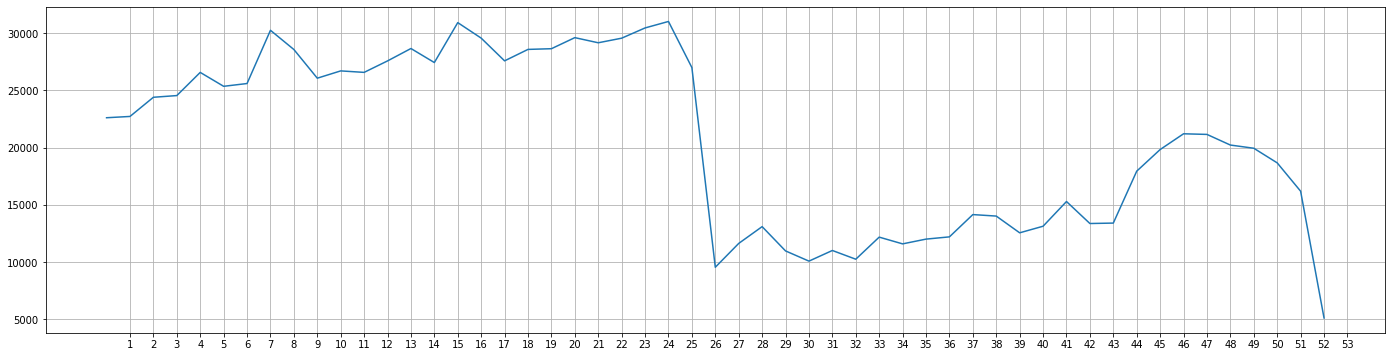

In [ ]:
df_weekly = df.groupby(df.index.week, as_index=False)['Vehicles'].sum()
plt.figure(figsize=(24, 6))
plt.plot(df_weekly.index, df_weekly.Vehicles)
plt.xticks(df.Week.unique())
plt.grid()
plt.show()

In [ ]:
# small trend on increasing traffic
# seasonality

In [ ]:
df['Start_Vec'] = 0
df['End_Vec'] = 0
arr1 = df.iloc[1:, 2].values
arr2 = df.iloc[:-1, 2].values
df.iloc[:-1, -2] = arr1
df.iloc[:-1, -1] = arr2
df['VecDiff'] = df.Start_Vec - df.End_Vec
df.drop(['Start_Vec', 'End_Vec'], axis=1, inplace=True)

In [ ]:
arr2.shape

(48119,)

In [ ]:
# Models to try: hourly traffic, daily traffic, weekly traffic
# LinearRegression
# Floating window - weighted - exponential smoothing
# fbProphet
# ARIMA / SARIMA
# Boosting: LGBRegressor
# LSTM: Pytorch / Keras

In [ ]:
df['WeekDay'] = df.index.dayofweek
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Day'] = df.index.day 
df['Date'] = df.index.date
df['Week'] = df.index.week

In [ ]:
df.head(10)

,DateTime,Junction,Vehicles,ID,VecDiff,WeekDay,Month,Year,Day,Date,Week
DateTime,,,,,,,,,,,
2015-11-01 00:00:00,2015-11-01 00:00:00,1,15,20151101001,-2,6,11,2015,1,2015-11-01,44
2015-11-01 01:00:00,2015-11-01 01:00:00,1,13,20151101011,-3,6,11,2015,1,2015-11-01,44
2015-11-01 02:00:00,2015-11-01 02:00:00,1,10,20151101021,-3,6,11,2015,1,2015-11-01,44
2015-11-01 03:00:00,2015-11-01 03:00:00,1,7,20151101031,2,6,11,2015,1,2015-11-01,44
2015-11-01 04:00:00,2015-11-01 04:00:00,1,9,20151101041,-3,6,11,2015,1,2015-11-01,44
2015-11-01 05:00:00,2015-11-01 05:00:00,1,6,20151101051,3,6,11,2015,1,2015-11-01,44
2015-11-01 06:00:00,2015-11-01 06:00:00,1,9,20151101061,-1,6,11,2015,1,2015-11-01,44
2015-11-01 07:00:00,2015-11-01 07:00:00,1,8,20151101071,3,6,11,2015,1,2015-11-01,44
2015-11-01 08:00:00,2015-11-01 08:00:00,1,11,20151101081,1,6,11,2015,1,2015-11-01,44


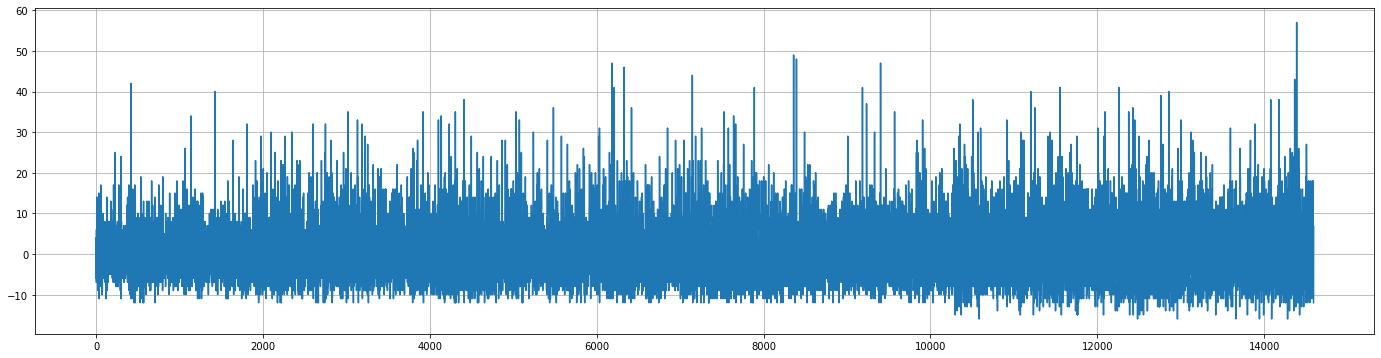

In [ ]:
df_daily = df.groupby(df.index, as_index=False)['VecDiff'].sum()
plt.figure(figsize=(24, 6))
plt.plot(df_daily.index, df_daily.VecDiff)
plt.grid()
plt.show()
# removed trend

In [ ]:
q1 = np.quantile(df.VecDiff, q=0.25)
q3 = np.quantile(df.VecDiff, q=0.75)
lower_bound = q3 - 1.5 * (q3 - q1)
df.loc[df.VecDiff < lower_bound, 'VecDiff'] = lower_bound

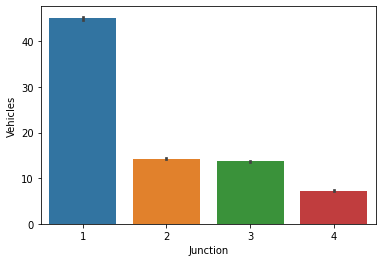

In [ ]:
sns.barplot(df.Junction, df.Vehicles)
plt.show()

In [ ]:
# seasonality: split day by two traffic preiods (group)
# remove outliers

In [ ]:
df[np.abs(df.VecDiff) > 80]

,DateTime,Junction,Vehicles,ID,VecDiff,WeekDay,Month,Year,Day,Date,Week
DateTime,,,,,,,,,,,
2016-07-15 17:00:00,2016-07-15 17:00:00,3,15,20160715173,83,4,7,2016,15,2016-07-15,28
2016-07-21 17:00:00,2016-07-21 17:00:00,3,16,20160721173,116,3,7,2016,21,2016-07-21,29
2017-02-23 18:00:00,2017-02-23 18:00:00,3,90,20170223183,90,3,2,2017,23,2017-02-23,8
2017-06-13 17:00:00,2017-06-13 17:00:00,3,25,20170613173,87,1,6,2017,13,2017-06-13,24
2017-06-22 13:00:00,2017-06-22 13:00:00,3,25,20170622133,137,3,6,2017,22,2017-06-22,25


In [ ]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    # mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    # print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
lgbreg = LGBMRegressor(boosting_type='goss', num_leaves=31, max_depth=-1, learning_rate=0.01, n_estimators=660,
                       subsample=1., colsample_bytree=0.3, random_state=1, reg_lambda=5., metric='mse')

In [ ]:
# every 12 hours - 1 feature
X = np.array([])
for idx in range(0, df.shape[0], 12):
    try:
        X = np.append(arr=X, values=df.VecDiff[idx: idx+12].reset_index()['VecDiff'].mean())
    except Exception as exc:
        print(f'{exc}')

In [ ]:
# every same hour every day during weekend - 1 feature

In [ ]:
# rolling window
weights = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
df.rolling(5).mean()[:10]

In [ ]:
# weighted rolling window
weights = np.linspace(0.1, 1, 12)
df_j1 = df.loc[df.Junction == 1, :]
X = df_j1[['Vehicles', 'VecDiff']].rolling(12).apply(lambda x: np.sum(weights * x))
# this is done here, but in other cases use rolling only for time dependent variables!

In [ ]:
X = X.dropna()

In [ ]:
X.head()

,Vehicles,VecDiff
DateTime,,
2015-11-01 11:00:00,75.627273,4.927273
2015-11-01 12:00:00,80.554545,3.881818
2015-11-01 13:00:00,84.436364,4.772727
2015-11-01 14:00:00,89.209091,0.336364
2015-11-01 15:00:00,89.545455,-0.109091


In [ ]:
y = df_j1.Vehicles[1:].rolling(12).apply(lambda x: np.sum(weights * x))

In [ ]:
y.dropna(inplace=True)

In [ ]:
X = X.iloc[:-1, :]

In [ ]:
X.shape, y.shape

((14580, 2), (14580,))

In [ ]:
X.iloc[0, :], y[0]

(Vehicles    75.627273
 VecDiff      4.927273
 Name: 2015-11-01 11:00:00, dtype: float64, 80.55454545454546)

In [ ]:
X, y = X.values, y.values

explained_variance:  0.9987
r2:  0.9986
MAE:  1.3873
MSE:  3.0944
RMSE:  1.7591
explained_variance:  0.9987
r2:  0.9987
MAE:  1.4261
MSE:  3.1536
RMSE:  1.7758
explained_variance:  0.9984
r2:  0.9984
MAE:  1.8044
MSE:  5.8987
RMSE:  2.4287
explained_variance:  0.9983
r2:  0.9982
MAE:  2.3679
MSE:  9.4142
RMSE:  3.0683
explained_variance:  0.9971
r2:  0.997
MAE:  2.9241
MSE:  14.9966
RMSE:  3.8725
explained_variance:  0.9973
r2:  0.9971
MAE:  2.7048
MSE:  10.1894
RMSE:  3.1921
explained_variance:  0.9976
r2:  0.9975
MAE:  2.4931
MSE:  9.3666
RMSE:  3.0605
explained_variance:  0.9963
r2:  0.9957
MAE:  2.4005
MSE:  7.6569
RMSE:  2.7671
explained_variance:  0.992
r2:  0.992
MAE:  2.7828
MSE:  12.7387
RMSE:  3.5691
explained_variance:  0.9926
r2:  0.9926
MAE:  2.8501
MSE:  11.603
RMSE:  3.4063


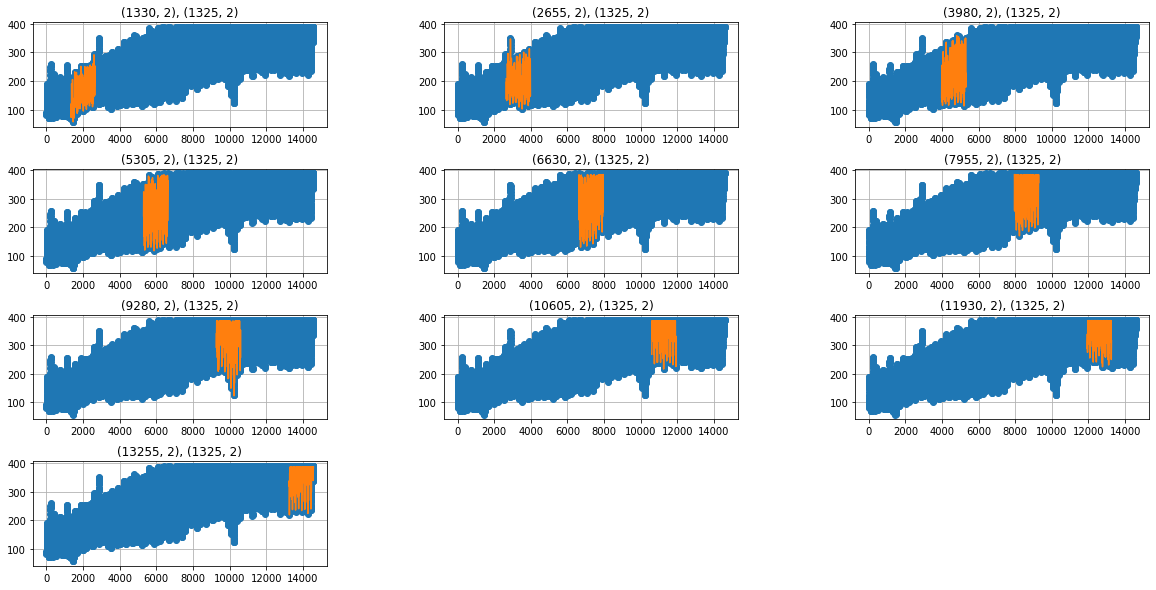

In [ ]:
split_iters = TimeSeriesSplit(n_splits=10).split(X)
results = []
plt.figure(figsize=(20, 10))
for i, (train_idxs, test_idxs) in enumerate(split_iters, 1):
    plt.subplot(4, 3, i)
    lr = make_pipeline(StandardScaler(), LinearRegression())
    X_train, X_test = X[train_idxs], X[test_idxs]
    y_train, y_test = y[train_idxs], y[test_idxs]
    plt.title(f'{X_train.shape}, {X_test.shape}')
    lr.fit(X_train, y_train)
    preds = lr.predict(X_test)
    plt.plot(y, 'o')
    plt.plot(test_idxs, preds)
    plt.grid()
    regression_results(y_test, preds)
    results.append(preds)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

In [ ]:
X[0, :], y[0]

(array([ 6.6       , 75.62727273,  4.92727273]), 80.55454545454546)

In [ ]:
# Exponential Smoothing

explained_variance:  0.9986
r2:  0.9983
MAE:  1.5943
MSE:  3.8429
RMSE:  1.9603
explained_variance:  0.9988
r2:  0.9987
MAE:  1.4671
MSE:  3.2283
RMSE:  1.7967
explained_variance:  0.9983
r2:  0.9982
MAE:  1.9956
MSE:  6.3936
RMSE:  2.5285
explained_variance:  0.9986
r2:  0.9984
MAE:  2.1782
MSE:  8.2936
RMSE:  2.8799
explained_variance:  0.9975
r2:  0.9971
MAE:  2.7287
MSE:  14.1518
RMSE:  3.7619
explained_variance:  0.9977
r2:  0.9977
MAE:  2.3336
MSE:  8.1294
RMSE:  2.8512
explained_variance:  0.9978
r2:  0.9978
MAE:  2.3027
MSE:  8.3956
RMSE:  2.8975
explained_variance:  0.9966
r2:  0.9963
MAE:  2.2209
MSE:  6.553
RMSE:  2.5599
explained_variance:  0.9921
r2:  0.9921
MAE:  2.7552
MSE:  12.6329
RMSE:  3.5543
explained_variance:  0.9926
r2:  0.9926
MAE:  2.8501
MSE:  11.603
RMSE:  3.4063


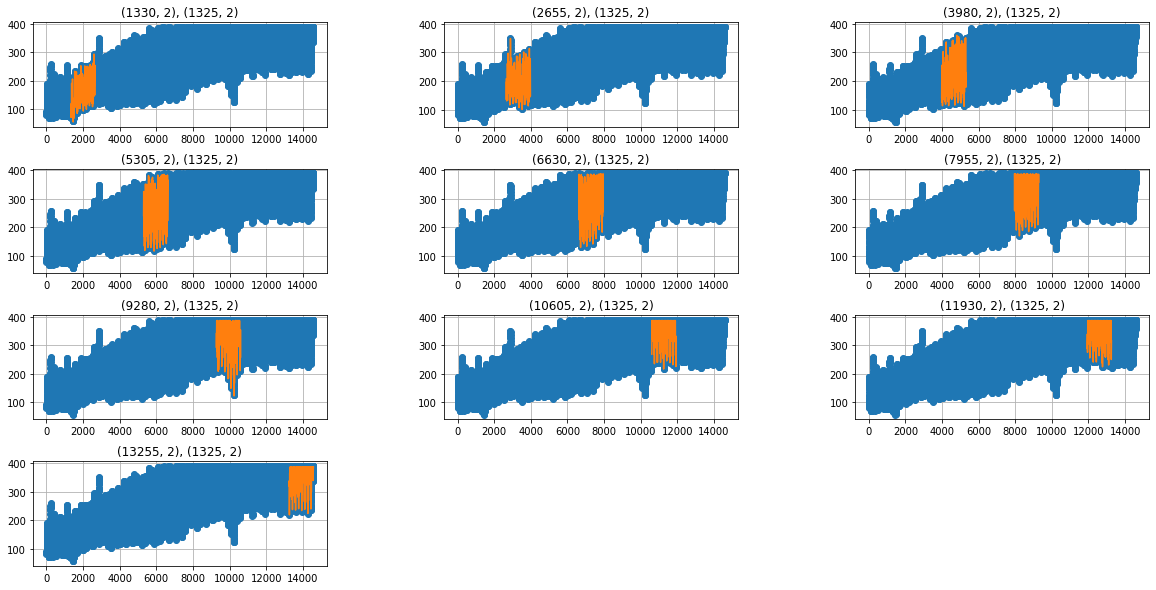

In [ ]:
split_iters = TimeSeriesSplit(n_splits=10).split(X)
results = []
plt.figure(figsize=(20, 10))
for i, (train_idxs, test_idxs) in enumerate(split_iters, 1):
    plt.subplot(4, 3, i)
    X_train, X_test = X[train_idxs], X[test_idxs]
    y_train, y_test = y[train_idxs], y[test_idxs]
    plt.title(f'{X_train.shape}, {X_test.shape}')
    lgbreg.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=False)
    preds = lr.predict(X_test)
    plt.plot(y, 'o')
    plt.plot(test_idxs, preds)
    plt.grid()
    regression_results(y_test, preds)
    results.append(preds)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

In [ ]:
# LSTM

In [ ]:
def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
import torch.optim as optim

In [ ]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["Vehicles"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n
    
input_dim = 12

df_generated = generate_time_lags(df, input_dim)

In [ ]:
df_generated.drop(['ID', 'WeekDay', 'Month', 'Year', 'Day', 'Date', 'Week'], axis=1, inplace=True)
df_generated.head()

,DateTime,Junction,Vehicles,VecDiff,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
DateTime,,,,,,,,,,,,,,,,
2015-11-01 12:00:00,2015-11-01 12:00:00,1,16.0,-1.0,17.0,15.0,12.0,11.0,8.0,9.0,6.0,9.0,7.0,10.0,13.0,15.0
2015-11-01 13:00:00,2015-11-01 13:00:00,1,15.0,1.0,16.0,17.0,15.0,12.0,11.0,8.0,9.0,6.0,9.0,7.0,10.0,13.0
2015-11-01 14:00:00,2015-11-01 14:00:00,1,16.0,-4.0,15.0,16.0,17.0,15.0,12.0,11.0,8.0,9.0,6.0,9.0,7.0,10.0
2015-11-01 15:00:00,2015-11-01 15:00:00,1,12.0,0.0,16.0,15.0,16.0,17.0,15.0,12.0,11.0,8.0,9.0,6.0,9.0,7.0
2015-11-01 16:00:00,2015-11-01 16:00:00,1,12.0,4.0,12.0,16.0,15.0,16.0,17.0,15.0,12.0,11.0,8.0,9.0,6.0,9.0


In [ ]:
df_generated_j1 = df_generated.loc[df_generated.Junction == 1, :]

In [ ]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_dataset(df, title):
    data = []
    value = go.Scatter(
        x=df.index,
        y=df.Vehicles,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)
plot_dataset(df, 'Traffic')

In [ ]:
plot_dataset(df.loc['2017-05-01'], '2017')

In [ ]:
df_features = (
                df_generated_j1
                .assign(hour = df_generated_j1.index.hour)
                .assign(day = df_generated_j1.index.day)
                .assign(month = df_generated_j1.index.month)
                .assign(day_of_week = df_generated_j1.index.dayofweek)
                .assign(week_of_year = df_generated_j1.index.week)
              )
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs).drop(columns=[col_name])

# removing cycles
df_features = generate_cyclical_features(df_features, 'hour', 24, 0)

In [ ]:
df_features.drop(['DateTime', 'Junction'], axis=1, inplace=True)

In [ ]:
df_features.head()

,Vehicles,VecDiff,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,day,month,day_of_week,week_of_year,sin_hour,cos_hour
DateTime,,,,,,,,,,,,,,,,,,,,
2015-11-01 12:00:00,16.0,-1.0,17.0,15.0,12.0,11.0,8.0,9.0,6.0,9.0,7.0,10.0,13.0,15.0,1,11,6,44,1.224647e-16,-1.000000
2015-11-01 13:00:00,15.0,1.0,16.0,17.0,15.0,12.0,11.0,8.0,9.0,6.0,9.0,7.0,10.0,13.0,1,11,6,44,-2.588190e-01,-0.965926
2015-11-01 14:00:00,16.0,-4.0,15.0,16.0,17.0,15.0,12.0,11.0,8.0,9.0,6.0,9.0,7.0,10.0,1,11,6,44,-5.000000e-01,-0.866025
2015-11-01 15:00:00,12.0,0.0,16.0,15.0,16.0,17.0,15.0,12.0,11.0,8.0,9.0,6.0,9.0,7.0,1,11,6,44,-7.071068e-01,-0.707107
2015-11-01 16:00:00,12.0,4.0,12.0,16.0,15.0,16.0,17.0,15.0,12.0,11.0,8.0,9.0,6.0,9.0,1,11,6,44,-8.660254e-01,-0.500000


In [ ]:
X, y = df_features.drop('Vehicles', axis=1), df_features['Vehicles']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

In [ ]:
X_train_std = torch.Tensor(X_train_std)
X_val_std = torch.Tensor(X_val_std)
X_test_std = torch.Tensor(X_test_std)
y_train = torch.Tensor(y_train)
y_val = torch.Tensor(y_val)
y_test = torch.Tensor(y_test)

In [ ]:
train_dataset = TensorDataset(X_train_std, y_train)
val_dataset = TensorDataset(X_val_std, y_val)
test_dataset = TensorDataset(X_test_std, y_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [ ]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        # model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        # torch.save(self.model.state_dict(), model_path)
    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_dim = X_train_std.shape[1]
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = GRUModel(**model_params).to(device)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)

[1/100] Training loss: 886.2871	 Validation loss: 1215.7785
[2/100] Training loss: 374.5640	 Validation loss: 765.1934
[3/100] Training loss: 251.1519	 Validation loss: 542.5619
[4/100] Training loss: 210.8033	 Validation loss: 426.9998
[5/100] Training loss: 193.1457	 Validation loss: 357.9862
[6/100] Training loss: 178.0477	 Validation loss: 304.4625
[7/100] Training loss: 159.2097	 Validation loss: 260.6726
[8/100] Training loss: 148.4987	 Validation loss: 226.9238
[9/100] Training loss: 141.3154	 Validation loss: 200.1083
[10/100] Training loss: 135.8485	 Validation loss: 180.0622
[50/100] Training loss: 118.8565	 Validation loss: 231.1714
[100/100] Training loss: 117.9126	 Validation loss: 218.2714


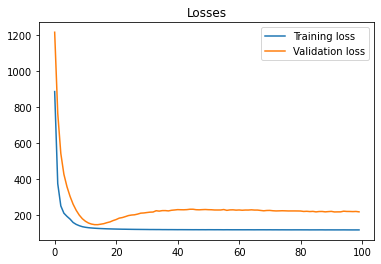

In [ ]:
opt.train(train_loader, valid_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

In [ ]:
predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:
# metrics
regression_results(y_test.detach().cpu().numpy(), np.array(predictions).squeeze())

explained_variance:  -0.0029
r2:  -1.6945
MAE:  13.1537
MSE:  214.6065
RMSE:  14.6495


In [ ]:
df_features.head()

,Vehicles,VecDiff,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,day,month,day_of_week,week_of_year,sin_hour,cos_hour
DateTime,,,,,,,,,,,,,,,,,,,,
2015-11-01 12:00:00,16.0,-1.0,17.0,15.0,12.0,11.0,8.0,9.0,6.0,9.0,7.0,10.0,13.0,15.0,1,11,6,44,1.224647e-16,-1.000000
2015-11-01 13:00:00,15.0,1.0,16.0,17.0,15.0,12.0,11.0,8.0,9.0,6.0,9.0,7.0,10.0,13.0,1,11,6,44,-2.588190e-01,-0.965926
2015-11-01 14:00:00,16.0,-4.0,15.0,16.0,17.0,15.0,12.0,11.0,8.0,9.0,6.0,9.0,7.0,10.0,1,11,6,44,-5.000000e-01,-0.866025
2015-11-01 15:00:00,12.0,0.0,16.0,15.0,16.0,17.0,15.0,12.0,11.0,8.0,9.0,6.0,9.0,7.0,1,11,6,44,-7.071068e-01,-0.707107
2015-11-01 16:00:00,12.0,4.0,12.0,16.0,15.0,16.0,17.0,15.0,12.0,11.0,8.0,9.0,6.0,9.0,1,11,6,44,-8.660254e-01,-0.500000


In [ ]:
# ARIMA / SARIMA
# fbProphet

In [ ]:
df.head()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


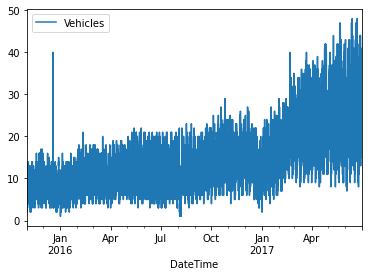

In [ ]:
df1 = df.loc[df.Junction == 2, :]
df1.drop(['Junction', 'ID'], axis=1, inplace=True)
df1.plot()

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df1['Vehicles'])

In [ ]:
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], result))
# the data is stationary

{'adf': -8.04107727559772,
 'criticalvalues': {'1%': -3.4307995466445482,
  '10%': -2.566875752496508,
  '5%': -2.8617386797172126},
 'icbest': 67639.25742620083,
 'nobs': 14549,
 'pvalue': 1.846368366770502e-12,
 'usedlag': 42}

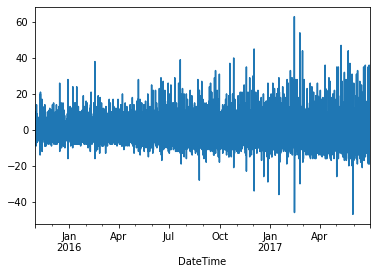

In [ ]:
# differencing to get stationarity
# continue differencing unless get p-value < 0.05
df1['1difference'] = df1['Vehicles'] - df1['Vehicles'].shift(1)
df1['1difference'].plot()

In [ ]:
result = adfuller(df1['1difference'].dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], result))

{'adf': -21.99759782265997,
 'criticalvalues': {'1%': -3.430799577550927,
  '10%': -2.566875759766632,
  '5%': -2.8617386933754303},
 'icbest': 85655.58070370097,
 'nobs': 14548,
 'pvalue': 0.0,
 'usedlag': 42}

In [ ]:
# https://towardsdatascience.com/arima-model-in-python-7bfc7fb792f9
# value d = 0 as if the first fuller test gived p-value < 0.05, unless d = number of differences made
# m parameter = 12 (if taking one observation as hour and the season is 12 hours: rush hours in traffic) 
# D value is only for seasonal data. 
"""
The seasonal difference can be computed by shifting the data by the number of rows per season 
(in our example 12 hours per half a day) and subtracting them from the previous season. 
This is not the first seasonal difference. If we get that the seasonal difference is stationary 
then the D value will be 0.
"""

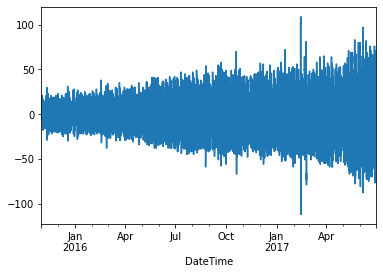

In [ ]:
df1['Seasonal_Difference'] = df1['Vehicles'] - df1['Vehicles'].shift(12)  # D parameter
ax = df1['Seasonal_Difference'].plot()

In [ ]:
result = adfuller((df1['Seasonal_Difference']).dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], result))  # so D = 0

{'adf': -20.09089426194575,
 'criticalvalues': {'1%': -3.430799917801785,
  '10%': -2.566875839804022,
  '5%': -2.8617388437398548},
 'icbest': 86108.97134941664,
 'nobs': 14537,
 'pvalue': 0.0,
 'usedlag': 42}

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
decompose = seasonal_decompose(df1.Vehicles, model='additive', extrapolate_trend='freq')

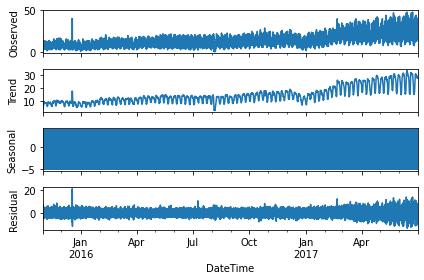

In [ ]:
decompose.plot()
plt.show()

In [ ]:
"""
AR: Autoregression. This indicates that the time series is regressed on its own lagged values.
I: Integrated. This indicates that the data values have been replaced with the difference between their 
   values and the previous values in order to convert the series into stationary.
MA: Moving Average. This indicates that the regression error is actually a linear combination of error terms 
    whose values occurred contemporaneously and at various times in the past.
"""

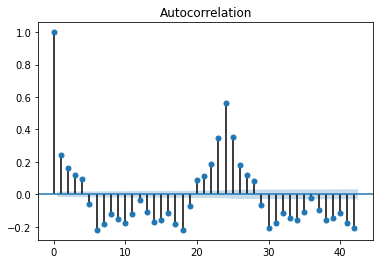

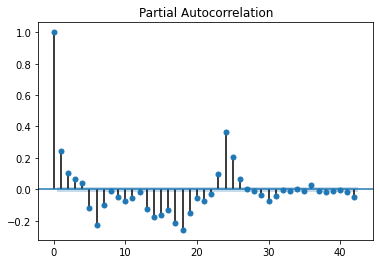

In [ ]:
fig1 = plot_acf(df1['1difference'].dropna())
fig2 = plot_pacf(df1['1difference'].dropna())

In [ ]:
"""
For non-seasonal data the parameters are:
p: The number of lag observations the model will use
d: The number of times that the raw observations are differenced till stationarity.
q: The size of the moving average window.

For seasonal data we need to add also the following:
P: The number of seasonal lag observations the model will use
D: The number of times that the seasonal observations are differenced till stationarity.
Q: The size of the seasonal moving average window.
m: The number of observations of 1 season
"""

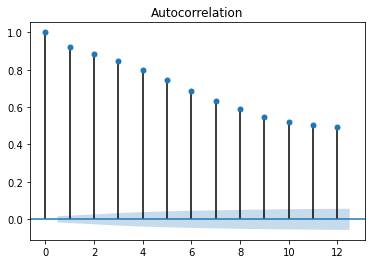

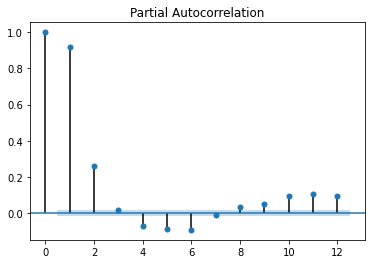

In [ ]:
fig1 = plot_acf(df1['Vehicles'].dropna(), lags=12)
fig2 = plot_pacf(df1['Vehicles'].dropna(), lags=12)

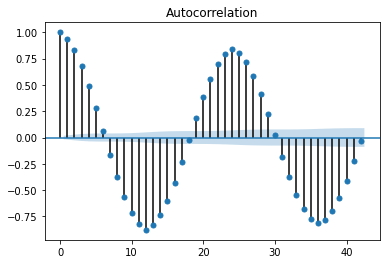

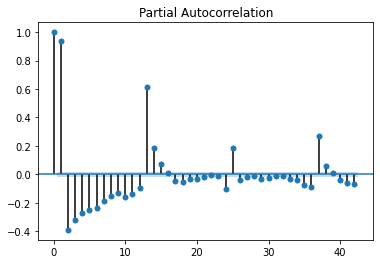

In [ ]:
fig1 = plot_acf(df1['Seasonal_Difference'].dropna())
fig2 = plot_pacf(df1['Seasonal_Difference'].dropna())

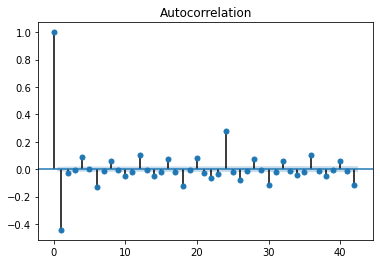

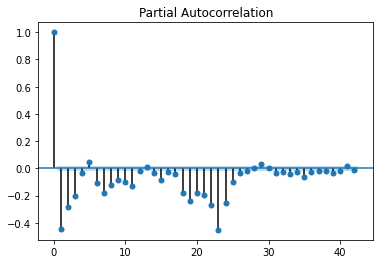

In [ ]:
df1['2difference'] = df1['1difference'] - df1['1difference'].shift(1)
fig1 = plot_acf(df1['2difference'].dropna())
fig2 = plot_pacf(df1['2difference'].dropna())

In [ ]:
# if our data is not seasonal, then d=0, p=1, q=1

In [ ]:
!pip install pmdarima

    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from pmdarima.arima import auto_arima
# acf pacf
# 1) search cut-offs
# 2) search first intercept with confidence intervals
# 3) look count exterbal lags

In [ ]:
step_wise = auto_arima(df1.Vehicles, start_p=0, start_q=0,  max_p=12, max_q=12,  d=0, max_d=3, trend='c',
                       trace=True, error_action='ignore', suppress_warnings=True, stepwise=True) # 1-2, 0, 0

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=99829.647, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=72610.911, Time=1.32 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=88349.362, Time=3.94 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=99829.647, Time=0.45 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=71569.449, Time=2.52 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=71565.851, Time=4.02 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=71494.141, Time=4.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=71377.910, Time=5.50 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=71252.342, Time=8.39 sec
 ARIMA(7,0,0)(0,0,0)[0] intercept   : AIC=71252.213, Time=10.37 sec
 ARIMA(8,0,0)(0,0,0)[0] intercept   : AIC=71235.756, Time=10.46 sec
 ARIMA(9,0,0)(0,0,0)[0] intercept   : AIC=71200.073, Time=15.67 sec
 ARIMA(10,0,0)(0,0,0)[0] intercept   : AIC=71068.886, Time=17.62 sec
 ARIMA(11,0,0)(0,0,0)[0] intercept   : AIC=70903.296, Time=22.04 sec
 ARIMA(12,0,

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
df1.head(1)

,Vehicles
DateTime,
2015-11-01,6


In [ ]:
X_train, X_test = train_test_split(df1, test_size=0.2, shuffle=False, random_state=1)

In [ ]:
X_train.iloc[1, :]

Vehicles    6
Name: 2015-11-01 01:00:00, dtype: int64

In [ ]:
model = SARIMAX(df1.Vehicles[:X_train.shape[0]], order=(12, 0, 0), seasonal_order=(0, 0, 0, 0), trend='c')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [ ]:
result = model.fit()

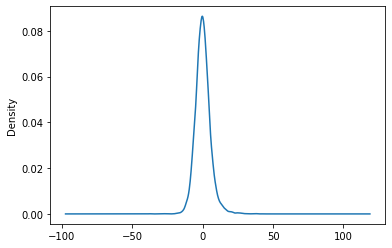

In [ ]:
result.resid.plot(kind='kde')

In [ ]:
from pandas.tseries.offsets import DateOffset

In [ ]:
new_dates = [X_train.index[-1] + DateOffset(hours=x) for x in range(1,2920)]
df_pred = pd.DataFrame(index=new_dates, columns=df1.columns)

In [ ]:
df_test = pd.concat([X_train, df_pred])

In [ ]:
X_train.shape, X_test.shape, df_test.shape

((11673, 1), (2919, 1), (14592, 1))

In [ ]:
df_test['predictions'] = result.predict(start=11673, end=14591)

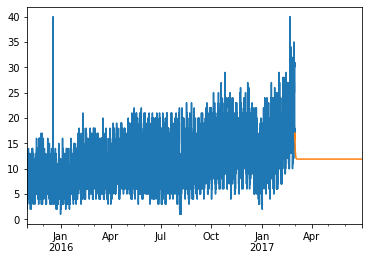

In [ ]:
df_test['Vehicles'].plot()
df_test['predictions'].plot()

In [ ]:
regression_results(X_test.Vehicles, df_test.predictions[-2919:])

explained_variance:  -0.0004
r2:  -2.0411
MAE:  11.9008
MSE:  206.7975
RMSE:  14.3805


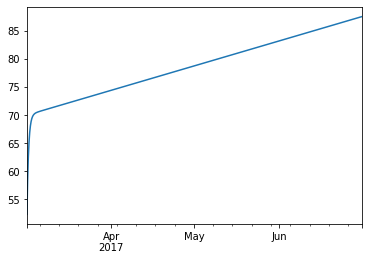

In [ ]:
df_test.predictions[-2919:].plot()

In [ ]:
!pip install pmdarima

In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

In [ ]:
pro = Prophet()

In [ ]:
fit_df = df.iloc[:, 1].reset_index().iloc[:X_train.shape[0], :2]

In [ ]:
fit_df.rename(columns={'DateTime': 'ds', 'Vehicles': 'y'}, inplace=True)

In [ ]:
pro.fit(fit_df)

In [ ]:
future = pro.make_future_dataframe(periods=X_test.shape[0])

In [ ]:
forecast = pro.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
14587,2025-02-22 08:00:00,360.415038,-1126.531973,1687.496611
14588,2025-02-23 08:00:00,353.339733,-1133.529736,1674.659037
14589,2025-02-24 08:00:00,368.352351,-1117.125508,1686.944362
14590,2025-02-25 08:00:00,373.509697,-1120.305522,1693.916552
14591,2025-02-26 08:00:00,371.517472,-1121.087006,1696.633666


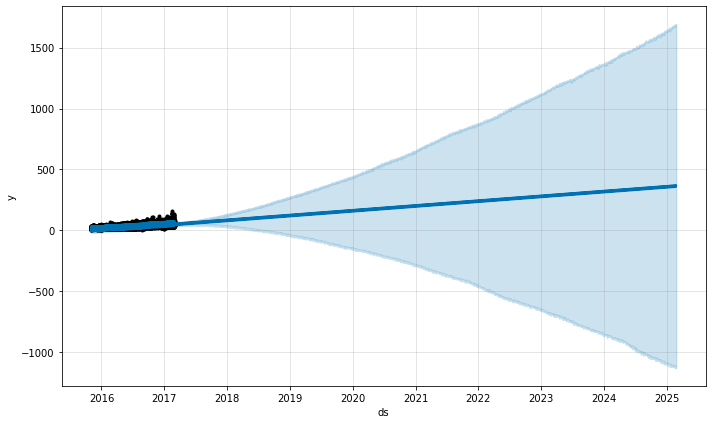

In [ ]:
figr = pro.plot(forecast)

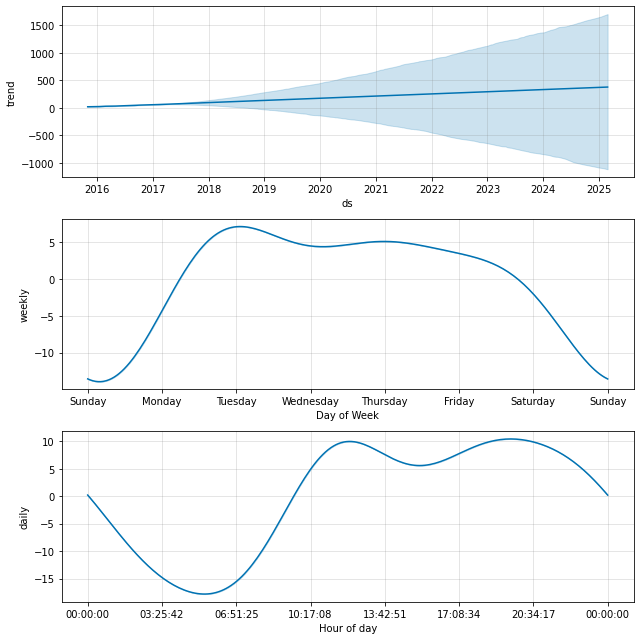

In [ ]:
figr2 = pro.plot_components(forecast)